# Assessing RMSD, RMSF and PCA of MD simulation

Usage: function plotting will plot rmsd, rmsd histogram, rmsf and PCA projection

In [2]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
#XRD Ensemble
#28 4NPQ
#18 4HFI

In [3]:
def rmsd_dataframe(traj_name, ref_name, location = '/media/scottzhuang/data/MD/'):
    
    traj_location = location +  traj_name
    top_location = location + ref_name
    ref_location = location + ref_name

    traj = md.load(traj_location,top=top_location)
    ref = md.load(ref_location)
    topology = traj.topology
    if traj.n_atoms != ref.n_atoms:
        traj = traj.atom_slice(topology.select(residue_selection))
    traj.superpose(ref)
    rmsd_data = pd.DataFrame({'RMSD':md.rmsd(traj, ref)*10,'time':traj.time/1000})
    return rmsd_data

In [4]:
def rmsf_resid_dataframe(traj_name, ref_name, location = '/media/scottzhuang/data/MD/'):
    
    traj_location = location +  traj_name
    top_location = location + ref_name
    ref_location = location + ref_name
    
    traj = md.load(traj_location,top=top_location)
    ref = md.load(ref_location)
    topology = traj.topology
    if traj.n_atoms != ref.n_atoms:
        traj = traj.atom_slice(topology.select(residue_selection))
    traj.superpose(ref)
    traj = traj[:50]

    avg_xyz = np.mean(traj.xyz[:, :, :], axis=0)
    rmsf = np.sqrt(3*np.mean((traj.xyz[:, :, :] - avg_xyz)**2, axis=(0,2)))
    rmsd_data = pd.DataFrame({'RMSF':rmsf,'residue':list(range(0,traj.n_atoms))})
    return rmsd_data

In [5]:
def projection_on_combined_ppca_stand(traj_note, superpose_num = 28,location = '/media/scottzhuang/data/MD/',skip = 10,residue_selection_1 = "resSeq 13 to 197", residue_selection_2 = "resSeq 198 to 315"):
    """
          INPUT: traj_note: "4NPQ_PH70_md1_yzhuang/4NPQ_pH70_BA1_md1"
                 location: "/media/scottzhuang/data/MD/" (default)
                 skip: 1 (default)
                 residue_selection_1: ECD
                 residue_selection_2: TMD
             -> ref_name = traj_note + ".ca.gro"
                traj_name = traj_note + ".skip" + skip + ".ca.xtc"
                PCA coordinate of new ensemble(without outliers)
          OUTPUT: MD projection on XRD ensemble PCA figure
        
    """    
    def combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2):
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj.superpose(wholetraj,28)
        topology = wholetraj.topology
        wholetraj_sliced_ecd = wholetraj.atom_slice(topology.select(residue_selection_1))
        wholetraj_sliced_ecd.superpose(wholetraj_sliced_ecd,28)
        wholetraj_sliced_tmd = wholetraj.atom_slice(topology.select(residue_selection_2))
        wholetraj_sliced_tmd.superpose(wholetraj_sliced_tmd,28)
        ppca_ecd = PCA(n_components=1)
        ppca_tmd = PCA(n_components=1)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(wholetraj_sliced_ecd.xyz.reshape(wholetraj_sliced_ecd.n_frames, wholetraj_sliced_ecd.n_atoms * 3)), ppca_tmd.fit_transform(wholetraj_sliced_tmd.xyz.reshape(wholetraj_sliced_tmd.n_frames, wholetraj_sliced_tmd.n_atoms * 3))]    
        print(ppca_ecd.explained_variance_ratio_)
        print(ppca_tmd.explained_variance_ratio_)
        return partial_reduced_cartesian, wholetraj_sliced_ecd, wholetraj_sliced_tmd,ppca_ecd,ppca_tmd
    top_location = traj_note + '/' + traj_note + ".ca.gro"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2)
    traj = md.load(location + traj_location,top= location + top_location)
    topology = traj.topology
    traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
    traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))

    traj_sliced_ecd.superpose(wholetraj_sliced_ecd,superpose_num)
    traj_sliced_tmd.superpose(wholetraj_sliced_tmd,superpose_num)

    reduced_cartesian_ecd = ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3))
    reduced_cartesian_tmd = ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3))

    fig = plt.figure()
    plt.scatter(reduced_cartesian_ecd,reduced_cartesian_tmd,alpha=0.4,c=traj.time)
    cbar = plt.colorbar()
    plt.scatter(partial_reduced_cartesian[0], partial_reduced_cartesian[1],c='black',marker='^')
    plt.xlabel('PC1 ECD')
    plt.ylabel('PC1 TMD')
    plt.title('MD_Projection of ' + traj_note + ' on Combined Partial PC1  with ' + residue_selection_1 + ' and ' + residue_selection_2)
    cbar.set_label('time')
    plt.show()

In [6]:
def plotting(traj_note,location = '/media/scottzhuang/data/MD/',skip=10):
    """
          INPUT: traj_note: "4NPQ_PH70_md1_yzhuang/4NPQ_pH70_BA1_md1"
                 location: "/media/scottzhuang/data/MD/" (default)
                 skip: 1 (default)
             -> ref_name = traj_note + ".ca.gro"
                traj_name = traj_note + ".skip" + skip + ".ca.xtc"
          OUTPUT: RMSD, RMSD Histogram, RMSF plotting
        
    """
    top_location = traj_note + '/' + traj_note + ".ca.gro"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
    ref_name = top_location
    traj_name = traj_location
    rmsd = rmsd_dataframe(traj_name, ref_name,location)
    rmsf = rmsf_resid_dataframe(traj_name, ref_name,location)
    f = plt.figure()
    gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,:])
    rmsd.plot(x='time', y='RMSD', ax=ax1, legend=False,)
    rmsd.plot.hist(x='time',bins=100,ax=ax2, legend=False)
    rmsf.plot(x='residue', y='RMSF', legend=False, ax=ax3)
    ax1.set_title("RMSD")
    ax2.set_title("RMSD histogram")
    ax2.yaxis.set_visible(False)    
    ax3.set_title("RMSF",y=-0.6)
    ax2.set_xlim(1,3)
    f.suptitle(traj_note,y=-0.12,fontsize=14)
    projection_on_combined_ppca_stand(traj_note,location = location,skip=skip,)

In [7]:
def projection_on_combined_ppca_all(traj_notes, superpose_num = 28,location = '/media/scottzhuang/data/MD/',skip = 10,residue_selection_1 = "resSeq 13 to 197", residue_selection_2 = "resSeq 198 to 315"):
    """
          INPUT: traj_note: "4NPQ_PH70_md1_yzhuang/4NPQ_pH70_BA1_md1"
                 location: "/media/scottzhuang/data/MD/" (default)
                 skip: 1 (default)
                 residue_selection_1: ECD
                 residue_selection_2: TMD
             -> ref_name = traj_note + ".ca.gro"
                traj_name = traj_note + ".skip" + skip + ".ca.xtc"
                PCA coordinate of new ensemble(without outliers)
          OUTPUT: MD projection on XRD ensemble PCA figure
        
    """    
    def combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2):
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj.superpose(wholetraj,28)
        topology = wholetraj.topology
        wholetraj_sliced_ecd = wholetraj.atom_slice(topology.select(residue_selection_1))
        wholetraj_sliced_ecd.superpose(wholetraj_sliced_ecd,28)
        wholetraj_sliced_tmd = wholetraj.atom_slice(topology.select(residue_selection_2))
        wholetraj_sliced_tmd.superpose(wholetraj_sliced_tmd,28)
        ppca_ecd = PCA(n_components=1)
        ppca_tmd = PCA(n_components=1)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(wholetraj_sliced_ecd.xyz.reshape(wholetraj_sliced_ecd.n_frames, wholetraj_sliced_ecd.n_atoms * 3)), ppca_tmd.fit_transform(wholetraj_sliced_tmd.xyz.reshape(wholetraj_sliced_tmd.n_frames, wholetraj_sliced_tmd.n_atoms * 3))]    
        print(ppca_ecd.explained_variance_ratio_)
        print(ppca_tmd.explained_variance_ratio_)
        return partial_reduced_cartesian, wholetraj_sliced_ecd, wholetraj_sliced_tmd,ppca_ecd,ppca_tmd
    
    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2)
    fig = plt.figure()
    plt.scatter(partial_reduced_cartesian[0], partial_reduced_cartesian[1],c='black',marker='^')
    for traj_note in traj_notes:
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        traj = traj[:50]
        topology = traj.topology
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))
        traj_sliced_ecd.superpose(wholetraj_sliced_ecd,superpose_num)
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,superpose_num)
        reduced_cartesian_ecd = ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3))
        reduced_cartesian_tmd = ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3))
        plt.scatter(reduced_cartesian_ecd,reduced_cartesian_tmd,alpha=0.4,c=traj.time)
    cbar = plt.colorbar()

    plt.xlabel('PC1 ECD')
    plt.ylabel('PC1 TMD')
    plt.title('PPCA of ECD/TMD: ' + traj_notes[0][:traj_notes[0].find('md')-1])
    cbar.set_label('time')
    plt.savefig("/media/scottzhuang/data/MD/analysis/figures/" + traj_notes[0][:traj_notes[0].find('md')-1] + ".ppca.png")
    plt.show()

In [8]:
def plotting_all(traj_notes,location = '/media/scottzhuang/data/MD/',skip=10):
    """
          INPUT: traj_note: "4NPQ_PH70_md1_yzhuang/4NPQ_pH70_BA1_md1"
                 location: "/media/scottzhuang/data/MD/" (default)
                 skip: 1 (default)
             -> ref_name = traj_note + ".ca.gro"
                traj_name = traj_note + ".skip" + skip + ".ca.xtc"
          OUTPUT: RMSD, RMSD Histogram, RMSF plotting
        
    """
    f = plt.figure()
    gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,:])
    for traj_note in traj_notes:
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        ref_name = top_location
        traj_name = traj_location
        rmsd = rmsd_dataframe(traj_name, ref_name,location)
        rmsf = rmsf_resid_dataframe(traj_name, ref_name,location)
        rmsd.plot(x='time', y='RMSD', ax=ax1, legend=False,)
        rmsd.plot.hist(x='time',bins=100,ax=ax2, legend=False)
        rmsf.plot(x='residue', y='RMSF', legend=False, ax=ax3)
        ax1.set_title("RMSD")
        ax2.set_title("RMSD histogram")
        ax2.yaxis.set_visible(False)    
        ax3.set_title("RMSF",y=-0.6)
        ax2.set_xlim(1,3)
        f.suptitle(traj_notes[0][:traj_notes[0].find('md')-1],y=-0.12,fontsize=14)
    projection_on_combined_ppca_all(traj_notes,location = location,skip=skip)

In [9]:
traj_notess = [['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3'],['5NJY_F238L_pH70_md1',
                 '5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3'],['5NJY_I233T_pH70_md1',
                  '5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3'],['5NJY_F238LI233T_pH70_md1',
                  '5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3'],['5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3'],['5NJY_F238L_pH46_md1',
                 '5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3'],['5NJY_I233T_pH46_md1',
                  '5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3'],['5NJY_F238LI233T_pH46_md1',
                  '5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3'],['4HFI_pH46_md1','4HFI_pH46_md2','4HFI_pH46_md3'],['4HFI_F238L_pH46_md1',
                 '4HFI_F238L_pH46_md2','4HFI_F238L_pH46_md3'],['4HFI_I233T_pH46_md1',
                  '4HFI_I233T_pH46_md2','4HFI_I233T_pH46_md3'],['4HFI_F238LI233T_pH46_md1',
                  '4HFI_F238LI233T_pH46_md2','4HFI_F238LI233T_pH46_md3'],['4NPQ_pH70_md5','4NPQ_pH70_md6','4NPQ_pH70_md7'],['4NPQ_F238L_pH70_md3',
                 '4NPQ_F238L_pH70_md4','4NPQ_F238L_pH70_md5'],['4NPQ_I233T_pH70_md3',
                  '4NPQ_I233T_pH70_md4','4NPQ_I233T_pH70_md5'],['4NPQ_F238LI233T_pH70_md3',
                  '4NPQ_F238LI233T_pH70_md4','4NPQ_F238LI233T_pH70_md5'],['4HFI_pH70_md1'],['4NPQ_F238LI233T_pH46_md1'],
               ['4NPQ_F238L_pH46_md1','4NPQ_F238L_pH46_md2'],['4NPQ_pH46_md1'],['4NPQ_I233T_pH46_md1','4NPQ_I233T_pH46_md2','4NPQ_I233T_pH46_md3']]

In [10]:
traj_notes = ['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3','5NJY_F238L_pH70_md1',
                 '5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3','5NJY_I233T_pH70_md1',
                  '5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3','5NJY_F238LI233T_pH70_md1',
                  '5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3','5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3','5NJY_F238L_pH46_md1',
                 '5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3','5NJY_I233T_pH46_md1',
                  '5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3','5NJY_F238LI233T_pH46_md1',
                  '5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3','4HFI_pH46_md1','4HFI_pH46_md2','4HFI_pH46_md3','4HFI_F238L_pH46_md1',
                 '4HFI_F238L_pH46_md2','4HFI_F238L_pH46_md3','4HFI_I233T_pH46_md1',
                  '4HFI_I233T_pH46_md2','4HFI_I233T_pH46_md3','4HFI_F238LI233T_pH46_md1',
                  '4HFI_F238LI233T_pH46_md2','4HFI_F238LI233T_pH46_md3','4NPQ_pH70_md5','4NPQ_pH70_md6','4NPQ_pH70_md7','4NPQ_F238L_pH70_md3',
                 '4NPQ_F238L_pH70_md4','4NPQ_F238L_pH70_md5','4NPQ_I233T_pH70_md3',
                  '4NPQ_I233T_pH70_md4','4NPQ_I233T_pH70_md5','4NPQ_F238LI233T_pH70_md3',
                  '4NPQ_F238LI233T_pH70_md4','4NPQ_F238LI233T_pH70_md5','4HFI_pH70_md1','4NPQ_F238LI233T_pH46_md1',
               '4NPQ_F238L_pH46_md1','4NPQ_F238L_pH46_md2','4NPQ_pH46_md1','4NPQ_I233T_pH46_md1','4NPQ_I233T_pH46_md2','4NPQ_I233T_pH46_md3']

[ 0.75145125]
[ 0.78432453]


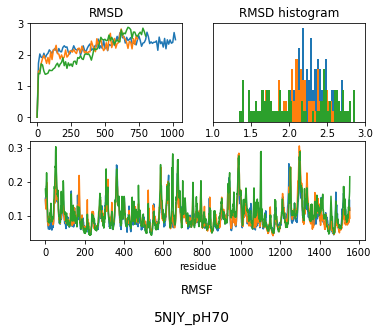

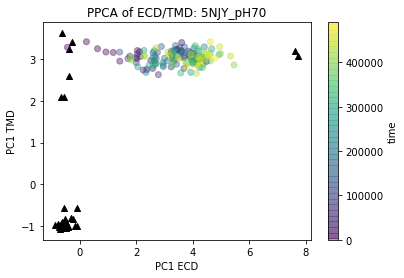

[ 0.75145113]
[ 0.78432453]


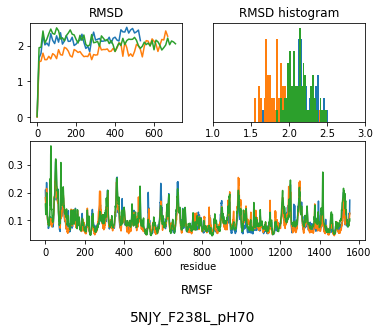

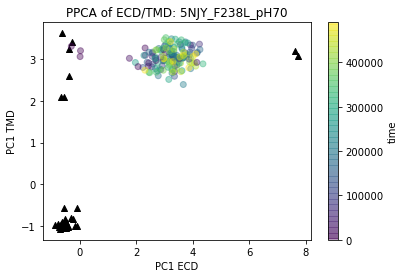

[ 0.75145102]
[ 0.78432453]


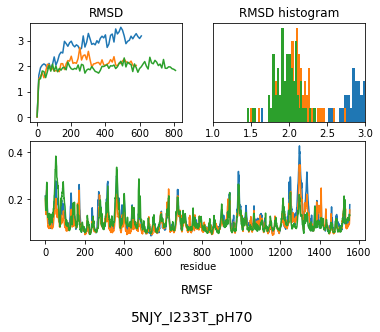

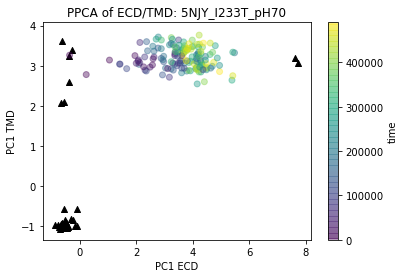

[ 0.75145113]
[ 0.78432471]


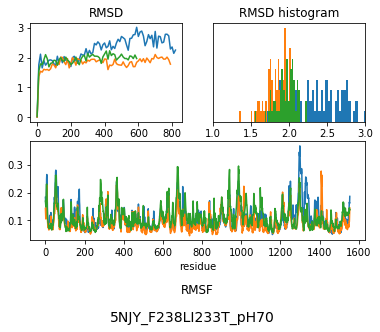

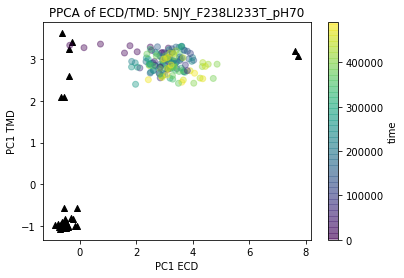

[ 0.75145113]
[ 0.78432453]


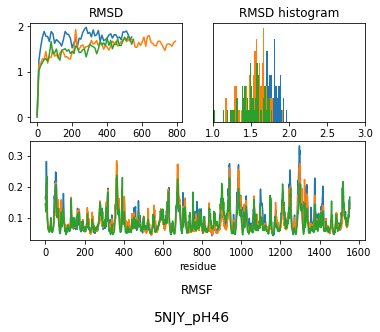

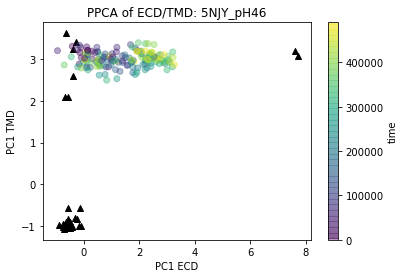

[ 0.75145125]
[ 0.78432471]


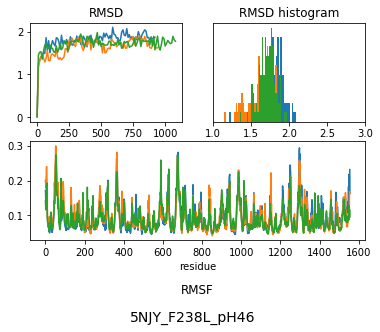

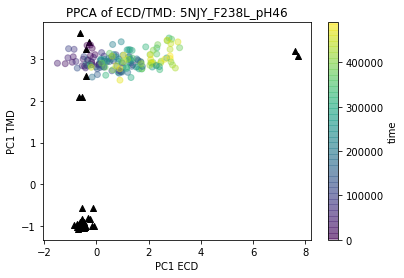

[ 0.75145125]
[ 0.78432453]


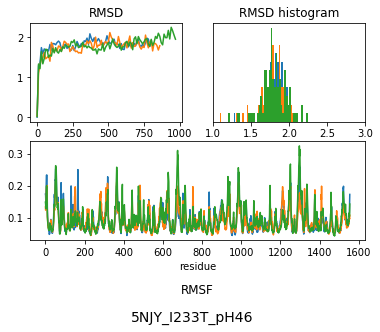

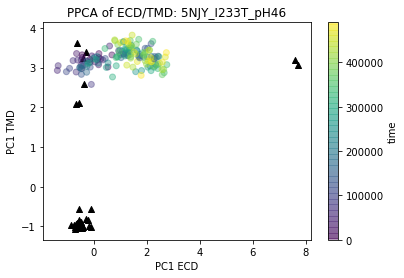

[ 0.75145113]
[ 0.78432471]


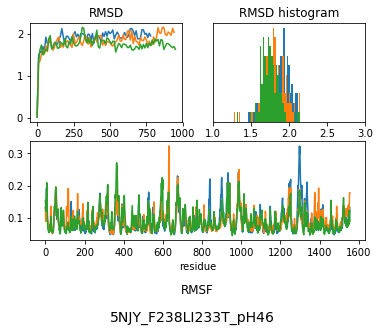

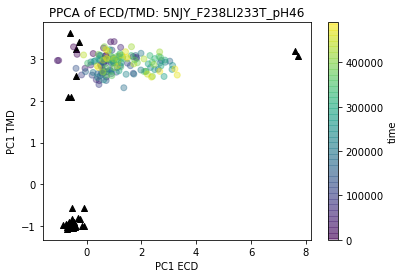

[ 0.7514509]
[ 0.78432453]


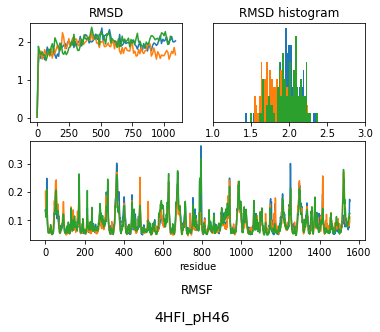

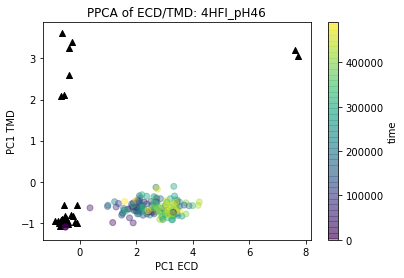

[ 0.75145113]
[ 0.78432471]


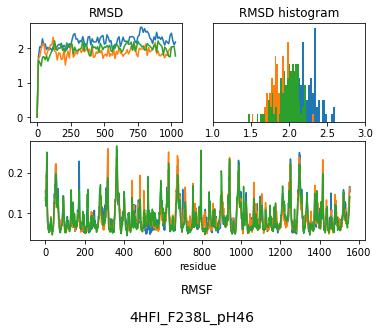

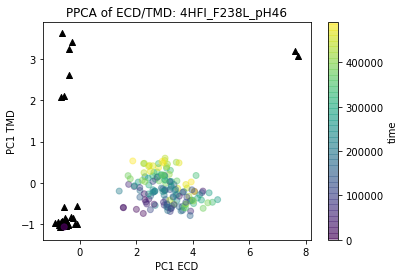

[ 0.75145113]
[ 0.78432453]


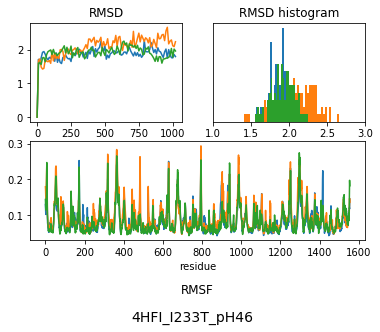

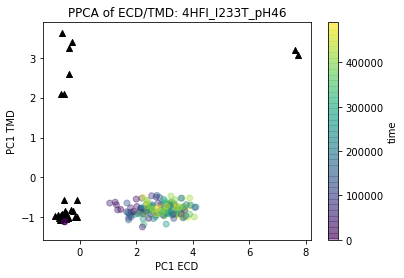

[ 0.75145113]
[ 0.78432453]


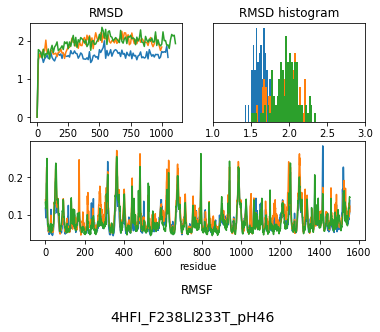

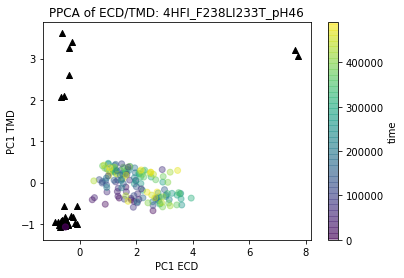

[ 0.75145113]
[ 0.78432453]


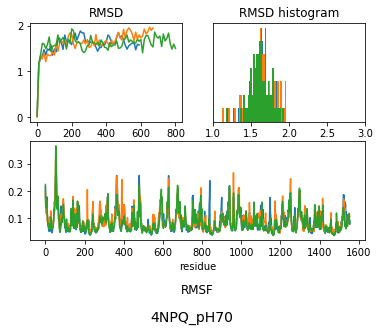

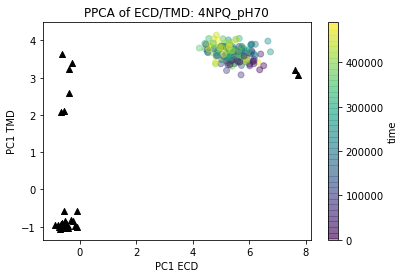

[ 0.75145113]
[ 0.78432453]


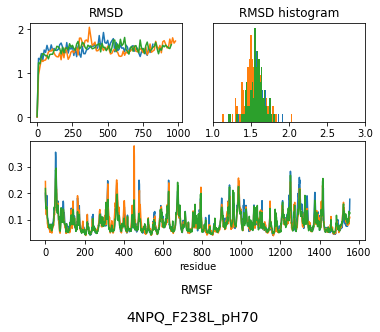

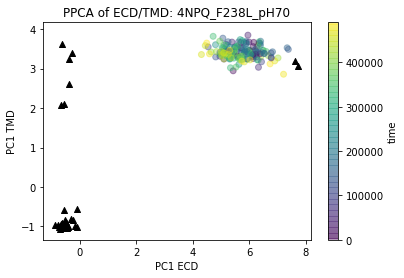

[ 0.75145102]
[ 0.78432453]


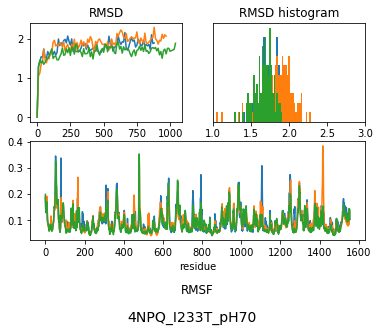

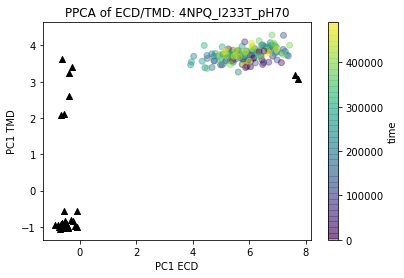

[ 0.75145113]
[ 0.78432471]


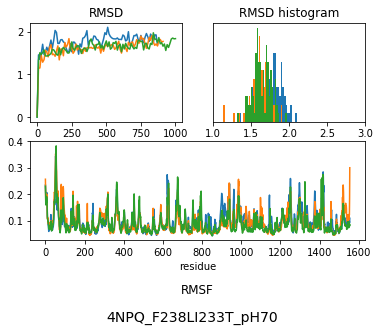

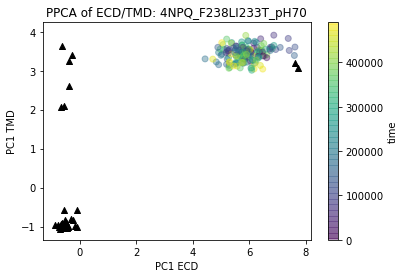

[ 0.75145102]
[ 0.78432471]


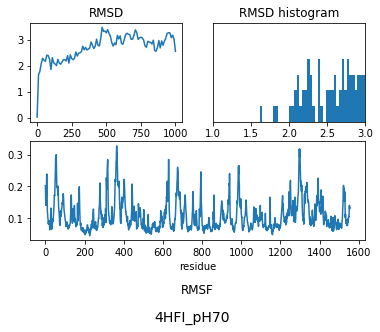

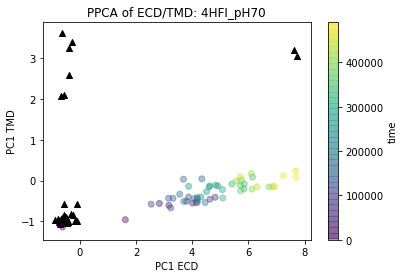

[ 0.75145102]
[ 0.78432453]


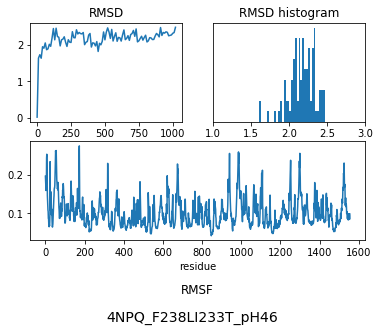

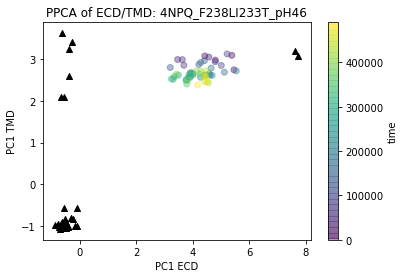

[ 0.7514509]
[ 0.78432441]


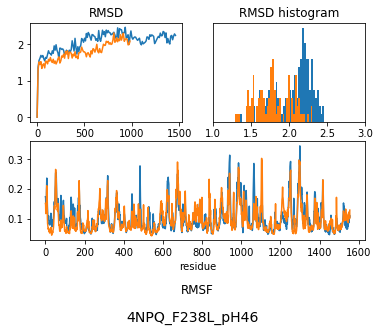

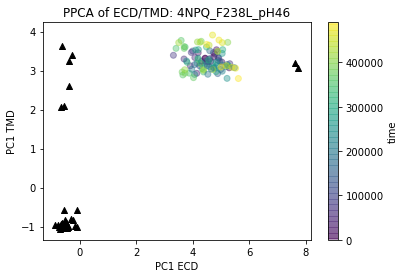

[ 0.75145113]
[ 0.78432471]


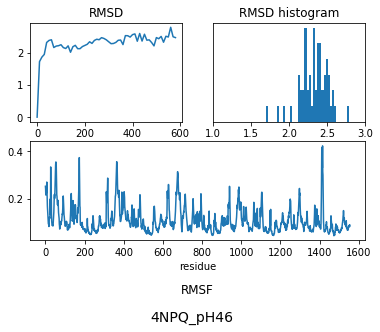

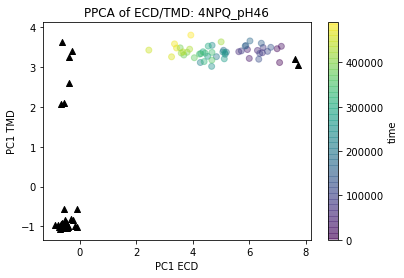

[ 0.75145113]
[ 0.78432471]


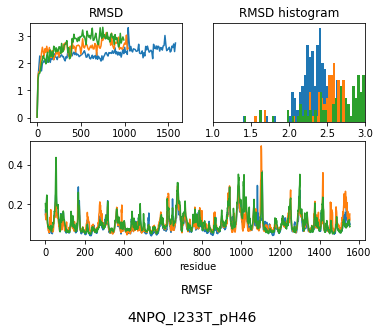

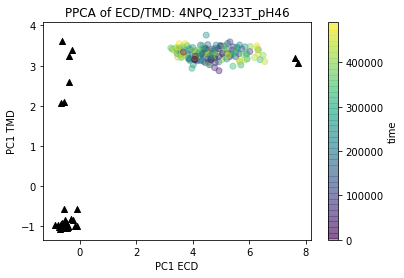

In [12]:
for traj_notes in traj_notess:
    plotting_all(traj_notes)

## 5NJY pH46

[ 0.75145113]
[ 0.78432453]


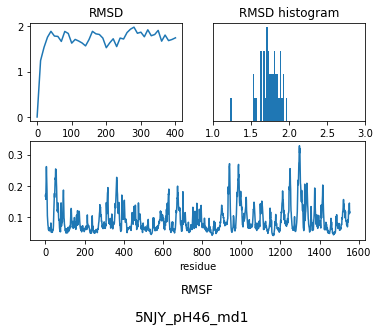

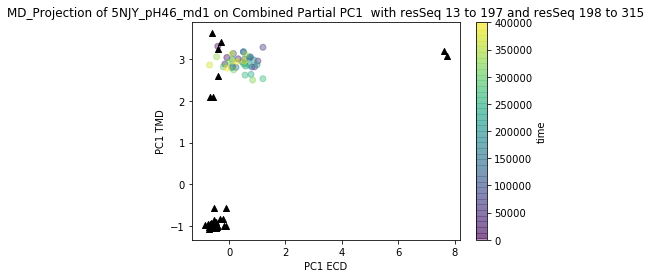

In [16]:
plotting("5NJY_pH46_md1")

[ 0.75145102]
[ 0.78432453]


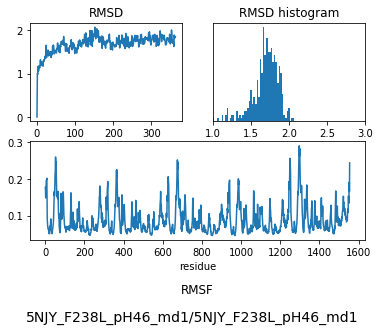

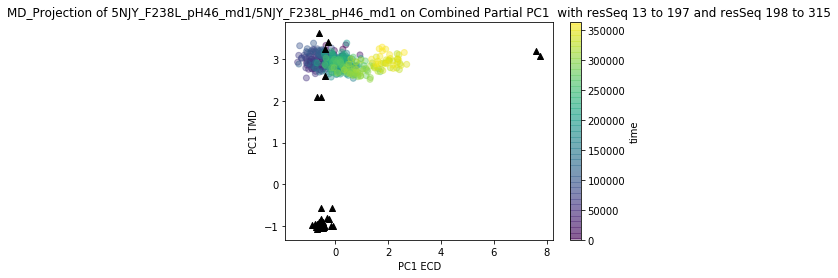

In [97]:
plotting("5NJY_F238L_pH46_md1")

[ 0.75145113]
[ 0.78432471]


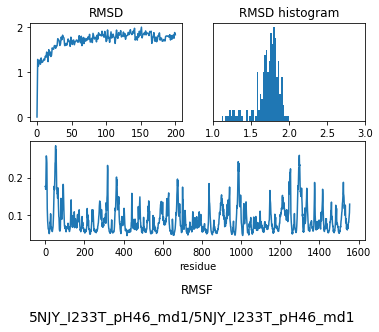

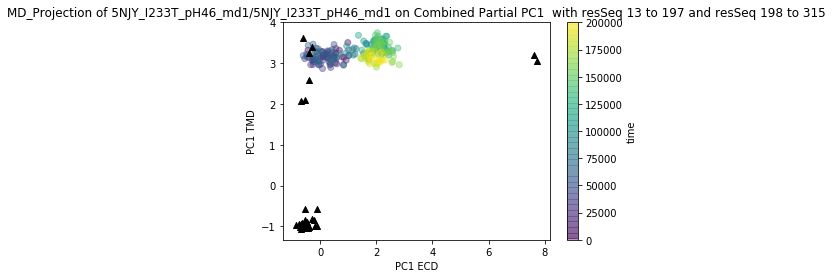

In [98]:
plotting("5NJY_I233T_pH46_md1/5NJY_I233T_pH46_md1")

[ 0.75145113]
[ 0.78432453]


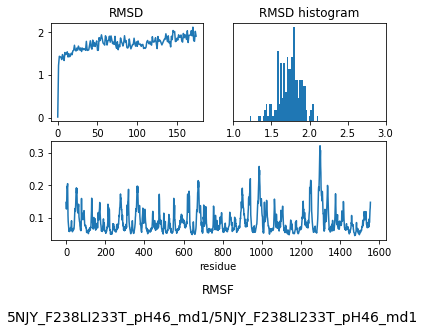

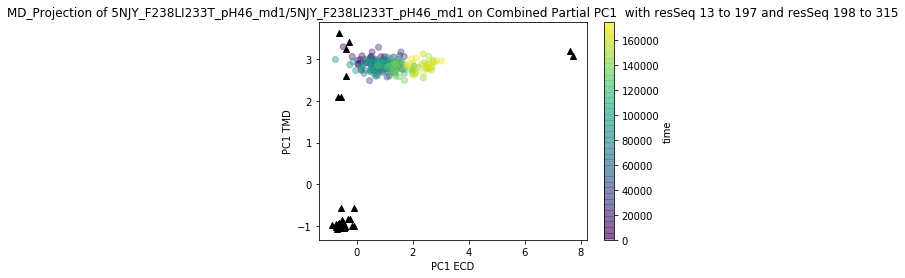

In [99]:
plotting("5NJY_F238LI233T_pH46_md1/5NJY_F238LI233T_pH46_md1")

## 5NJY_pH70

[ 0.75145113]
[ 0.78432453]


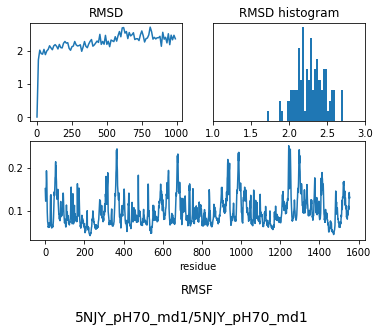

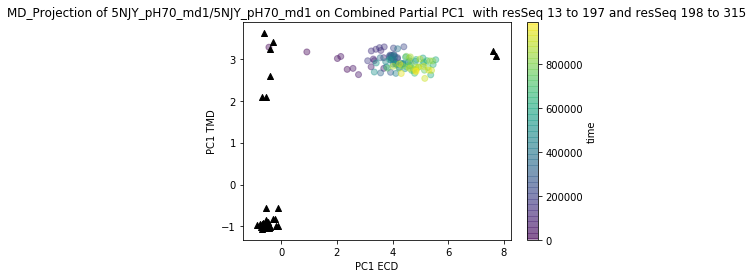

In [70]:
plotting("5NJY_pH70_md1/5NJY_pH70_md1",skip=10)

[ 0.75145125]
[ 0.78432453]


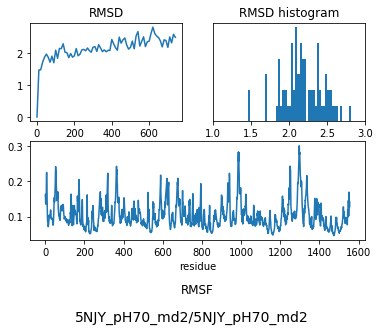

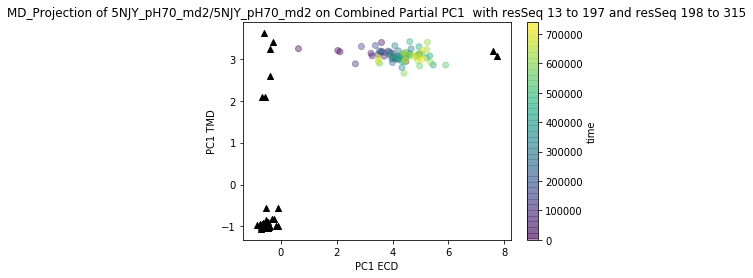

In [9]:
plotting("5NJY_pH70_md2/5NJY_pH70_md2",skip=10)

[ 0.75145125]
[ 0.78432453]


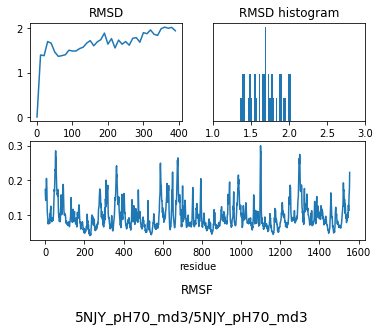

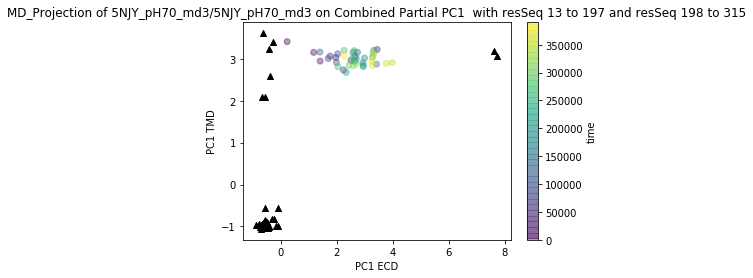

In [83]:
plotting("5NJY_pH70_md3/5NJY_pH70_md3",skip=10)

[ 0.75145137]
[ 0.78432453]


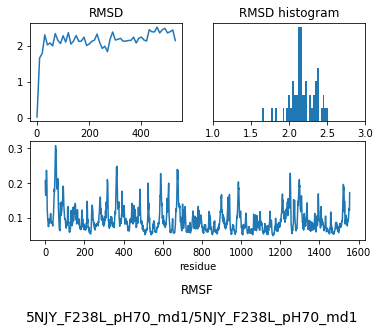

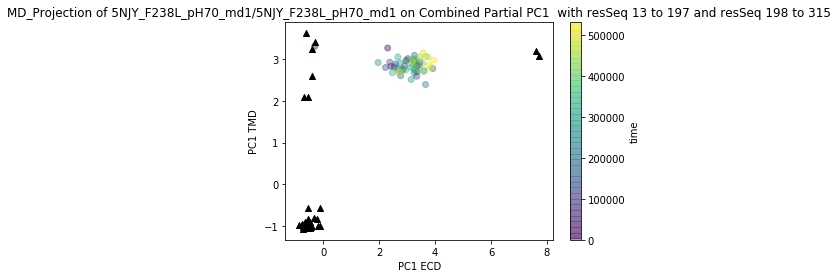

In [15]:
plotting("5NJY_F238L_pH70_md1/5NJY_F238L_pH70_md1",skip=10)

[ 0.75145125]
[ 0.78432453]


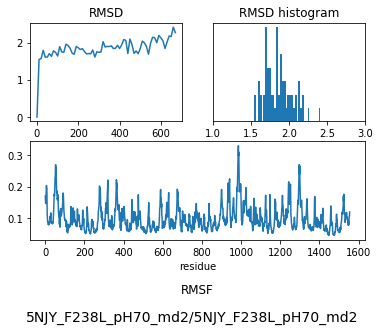

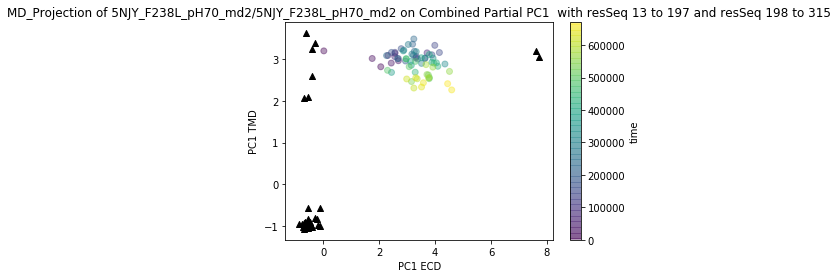

In [16]:
plotting("5NJY_F238L_pH70_md2/5NJY_F238L_pH70_md2",skip=10)

[ 0.75145102]
[ 0.78432453]


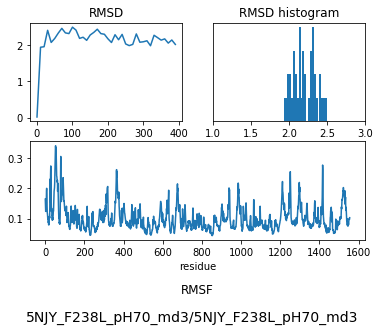

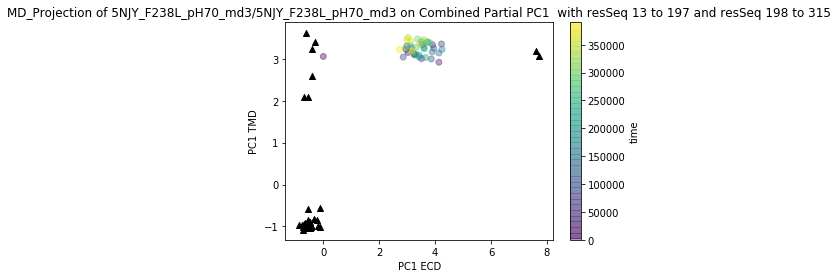

In [84]:
plotting("5NJY_F238L_pH70_md3/5NJY_F238L_pH70_md3",skip=10)

[ 0.75145113]
[ 0.78432471]


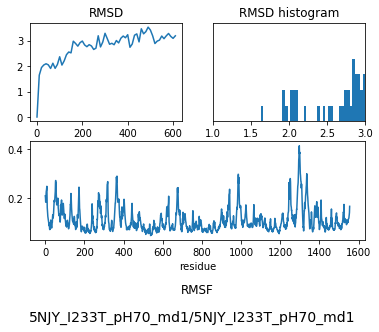

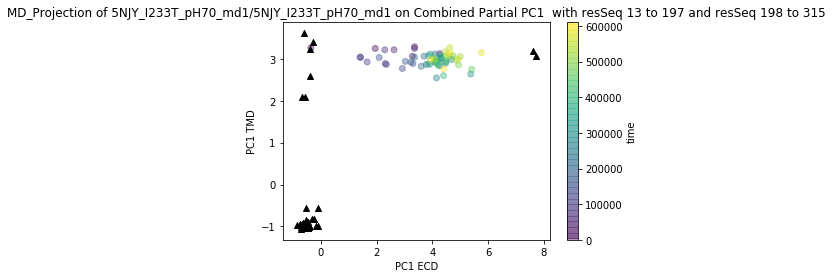

In [17]:
plotting("5NJY_I233T_pH70_md1/5NJY_I233T_pH70_md1",skip=10)

[ 0.75145113]
[ 0.78432453]


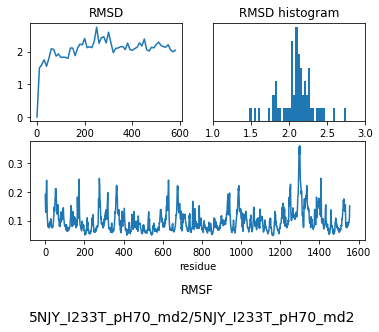

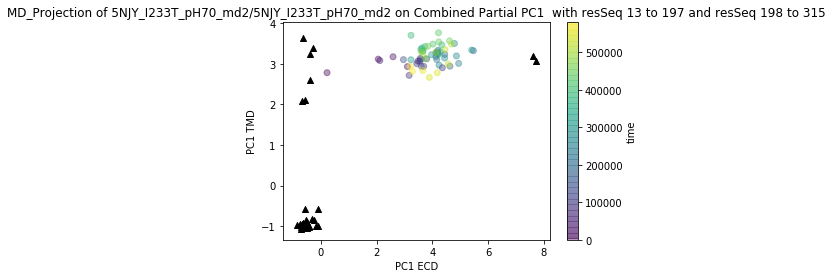

In [85]:
plotting("5NJY_I233T_pH70_md2/5NJY_I233T_pH70_md2",skip=10)

[ 0.75145102]
[ 0.78432471]


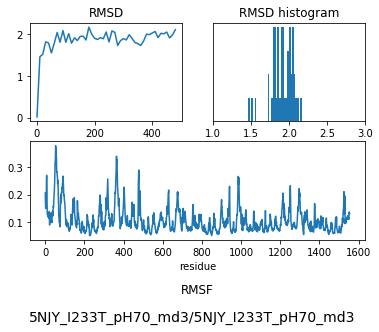

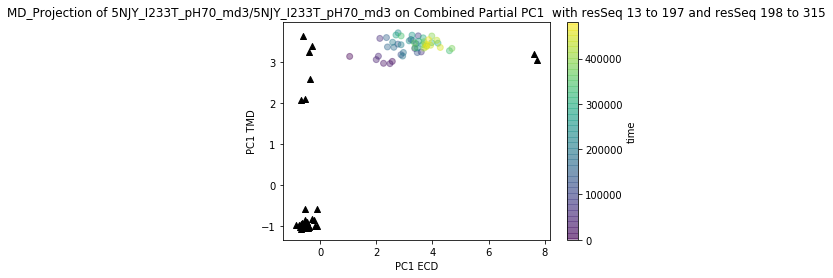

In [86]:
plotting("5NJY_I233T_pH70_md3/5NJY_I233T_pH70_md3",skip=10)

[ 0.75145113]
[ 0.78432471]


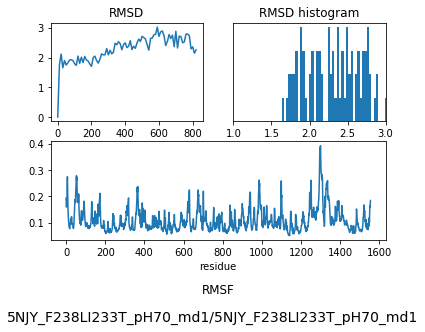

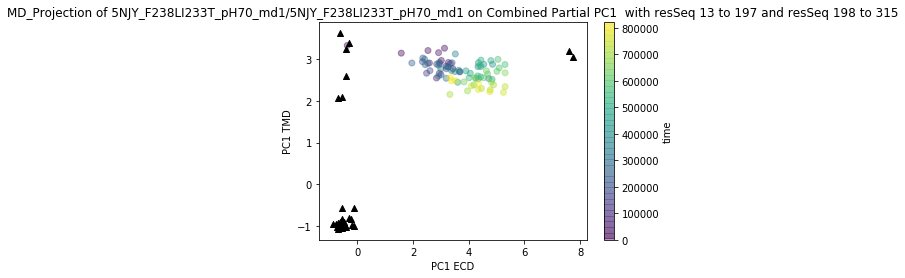

In [87]:
plotting("5NJY_F238LI233T_pH70_md1/5NJY_F238LI233T_pH70_md1",skip=10)

[ 0.75145113]
[ 0.78432453]


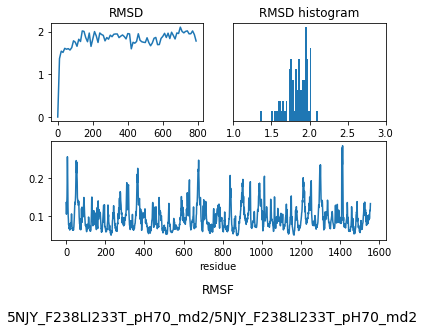

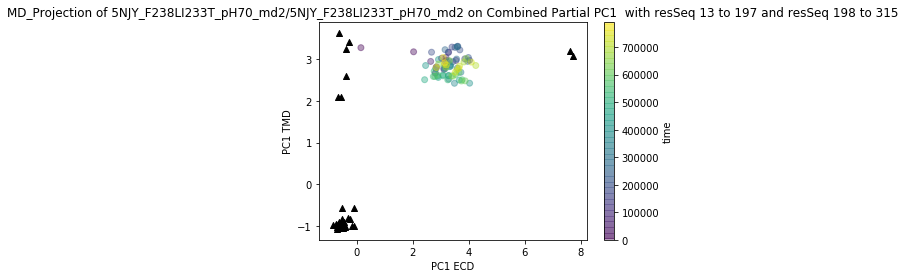

In [88]:
plotting("5NJY_F238LI233T_pH70_md2/5NJY_F238LI233T_pH70_md2",skip=10)

[ 0.75145113]
[ 0.78432453]


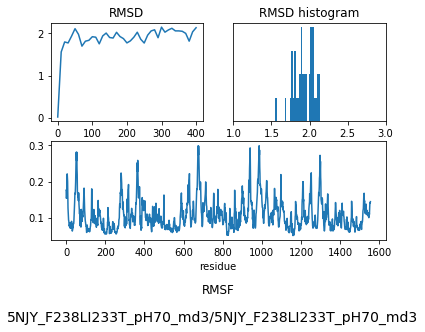

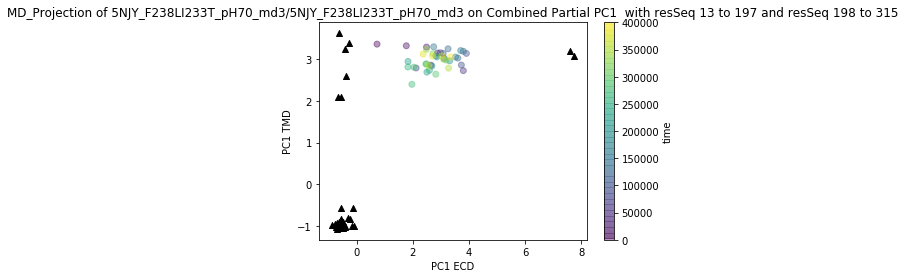

In [89]:
plotting("5NJY_F238LI233T_pH70_md3/5NJY_F238LI233T_pH70_md3",skip=10)

## New 4NPQ 70 Analysis

[ 0.75145113]
[ 0.78432453]


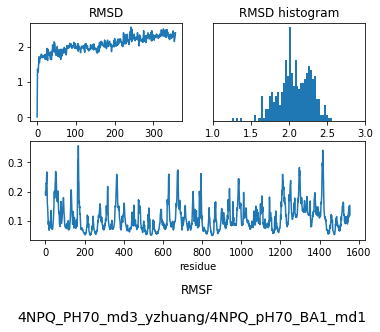

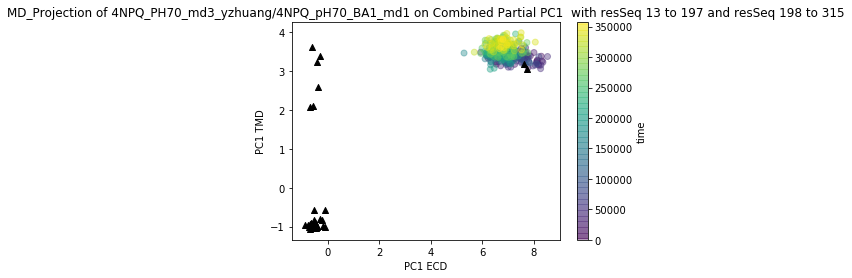

In [13]:
plotting("4NPQ_PH70_md3_yzhuang/4NPQ_pH70_BA1_md1")

[ 0.75145102]
[ 0.78432441]


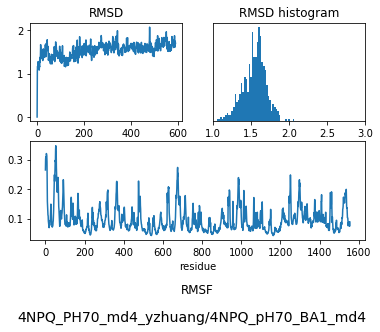

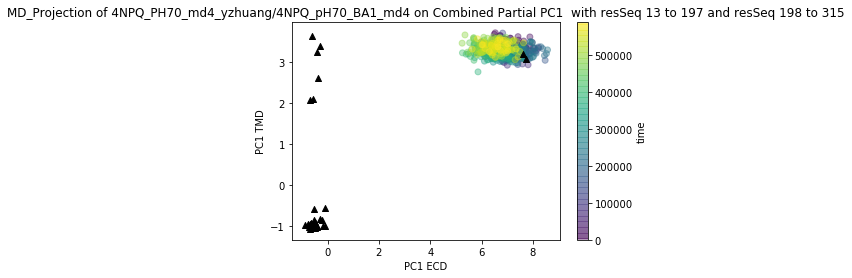

In [14]:
plotting("4NPQ_PH70_md4_yzhuang/4NPQ_pH70_BA1_md4")

[ 0.75145125]
[ 0.78432471]


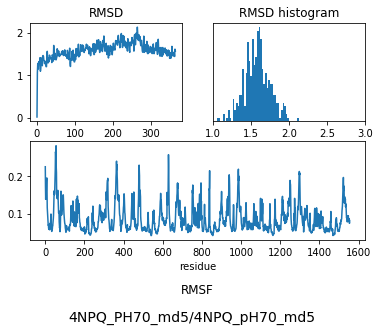

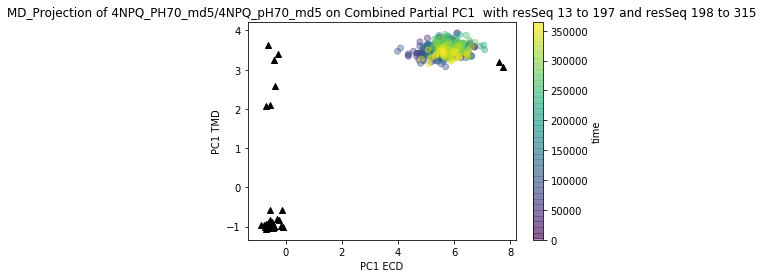

In [73]:
plotting("4NPQ_PH70_md5/4NPQ_pH70_md5")

[ 0.75145102]
[ 0.78432453]


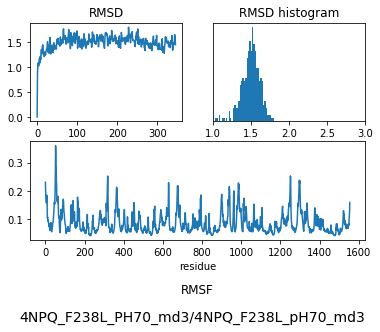

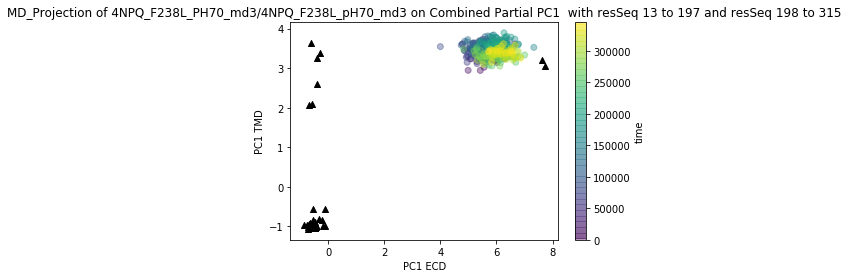

In [76]:
plotting("4NPQ_F238L_PH70_md3/4NPQ_F238L_pH70_md3")

[ 0.75145125]
[ 0.78432453]


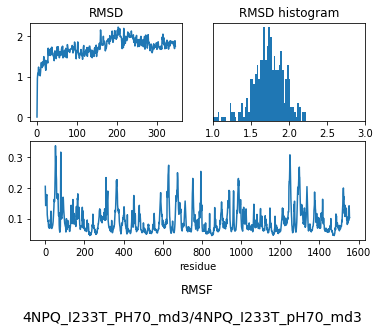

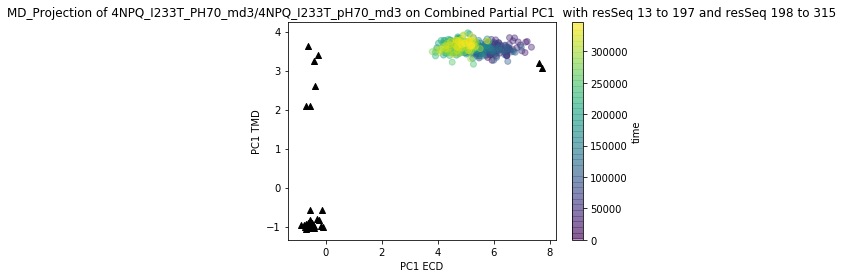

In [77]:
plotting("4NPQ_I233T_PH70_md3/4NPQ_I233T_pH70_md3")

[ 0.75145113]
[ 0.78432471]


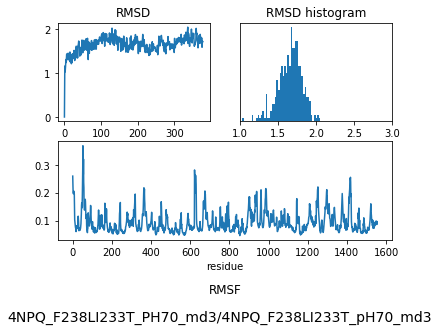

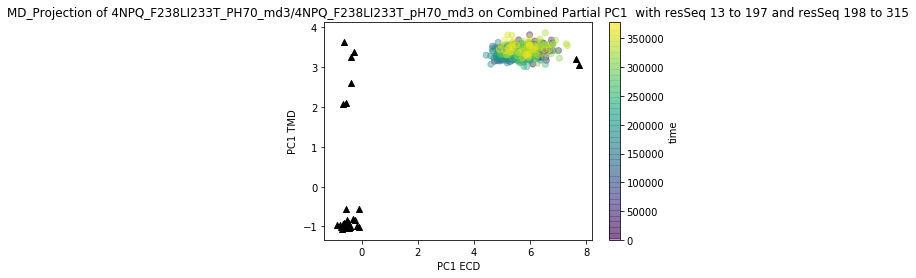

In [78]:
plotting("4NPQ_F238LI233T_PH70_md3/4NPQ_F238LI233T_pH70_md3")

## New 4HFI 46 Analysis

[ 0.75145102]
[ 0.78432441]


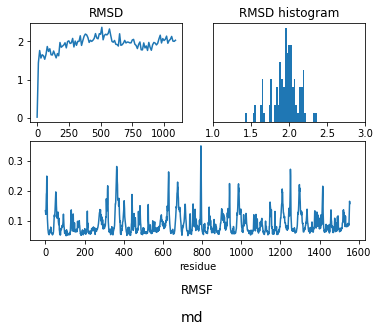

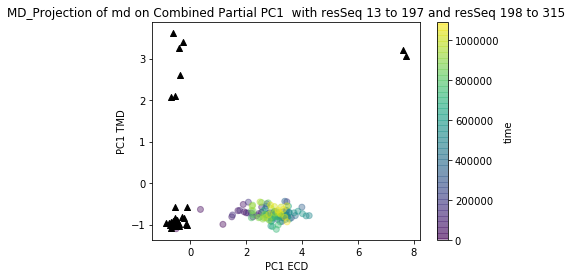

In [27]:
plotting("md","/media/scottzhuang/data/MD/4HFI_pH46/",skip=10)

[ 0.75145102]
[ 0.78432453]


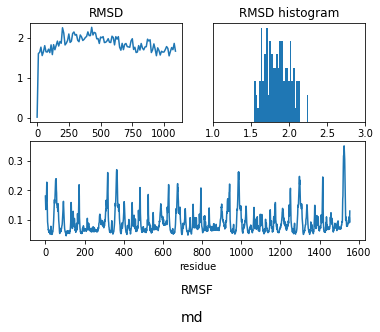

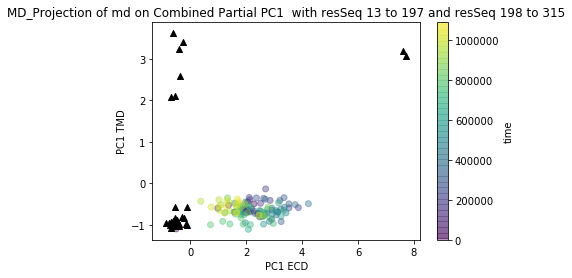

In [28]:
plotting("md","/media/scottzhuang/data/MD/4HFI_pH46/repli1/",skip=10)

[ 0.75145125]
[ 0.78432453]


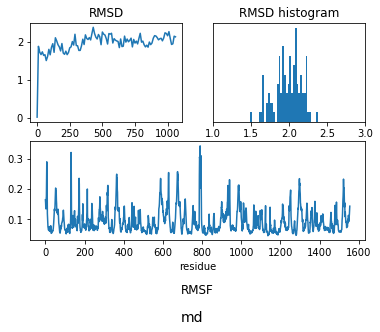

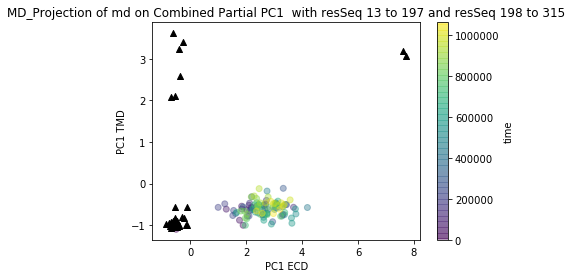

In [26]:
plotting("md","/media/scottzhuang/data/MD/4HFI_pH46/repli2/",skip=10)

[ 0.75145102]
[ 0.78432441]


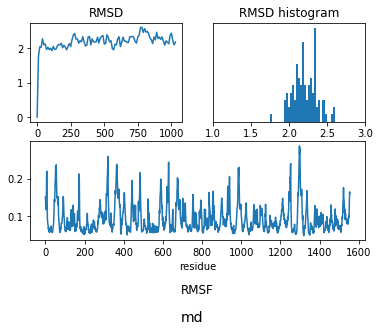

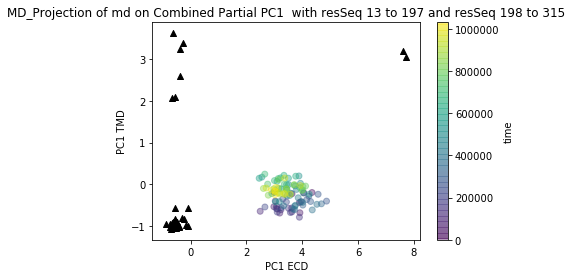

In [23]:
plotting("md","/media/scottzhuang/data/MD/4HFI_F238L_pH46/",skip=10)

[ 0.75145102]
[ 0.78432453]


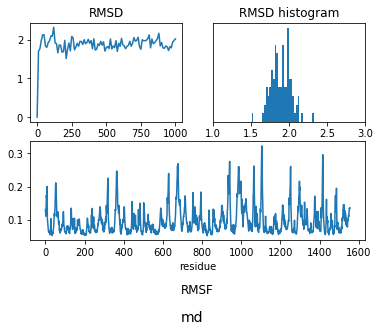

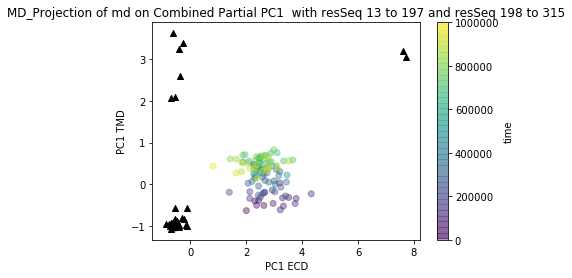

In [24]:
plotting("md","/media/scottzhuang/data/MD/4HFI_F238L_pH46/repli1/",skip=10)

[ 0.75145102]
[ 0.78432453]


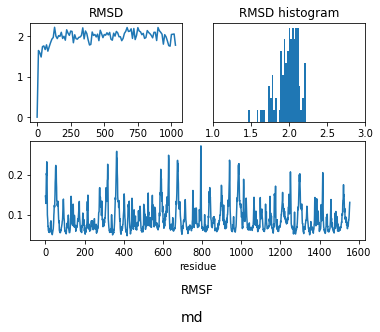

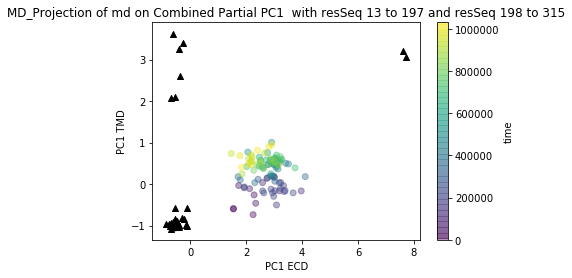

In [25]:
plotting("md","/media/scottzhuang/data/MD/4HFI_F238L_pH46/repli2/",skip=10)

[ 0.75145102]
[ 0.78432441]


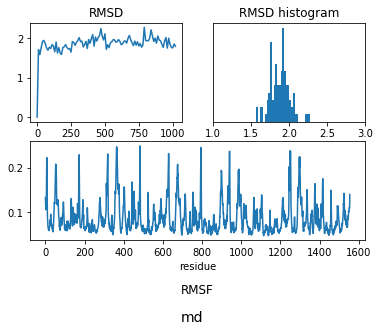

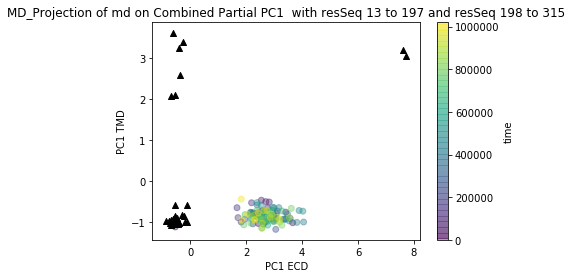

In [33]:
plotting("md","/media/scottzhuang/data/MD/4HFI_I233T_pH46/",skip=10)

[ 0.75145113]
[ 0.78432441]


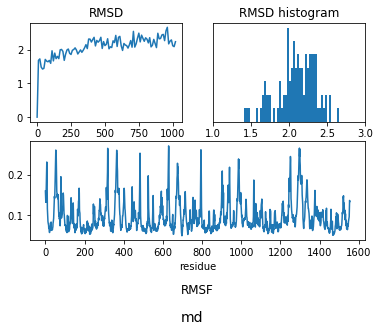

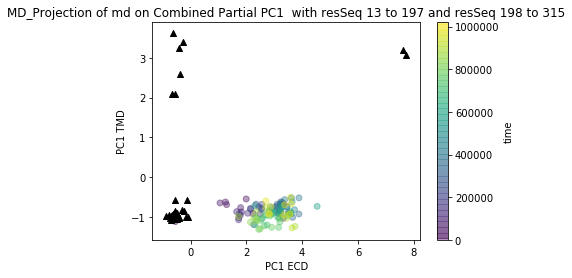

In [37]:
plotting("md","/media/scottzhuang/data/MD/4HFI_I233T_pH46/repli1/",skip=10)

[ 0.7514509]
[ 0.78432441]


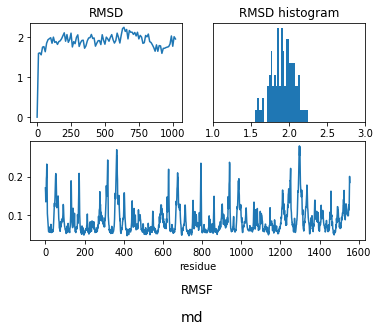

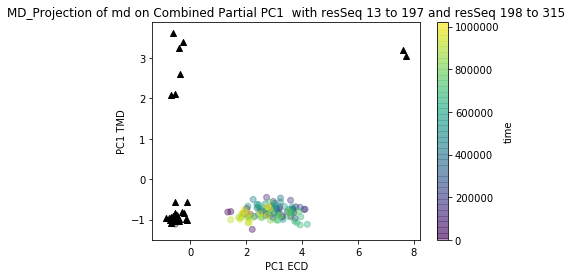

In [38]:
plotting("md","/media/scottzhuang/data/MD/4HFI_I233T_pH46/repli2/",skip=10)

[ 0.75145102]
[ 0.78432441]


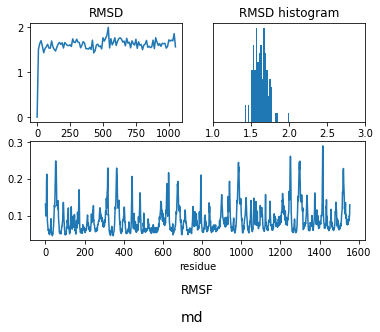

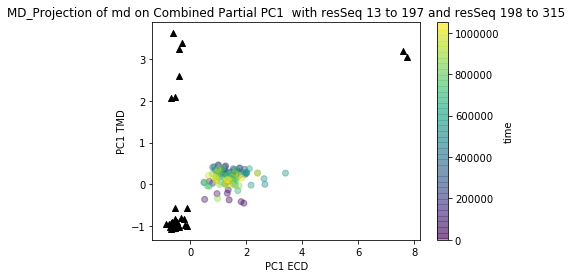

In [34]:
plotting("md","/media/scottzhuang/data/MD/4HFI_F238LI233T_pH46/",skip=10)

[ 0.75145102]
[ 0.78432453]


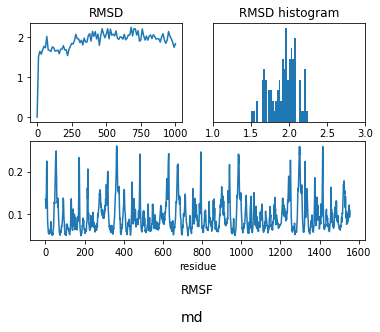

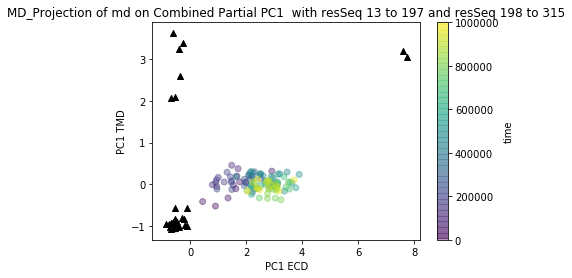

In [35]:
plotting("md","/media/scottzhuang/data/MD/4HFI_F238LI233T_pH46/repli1/",skip=10)

[ 0.75145102]
[ 0.78432453]


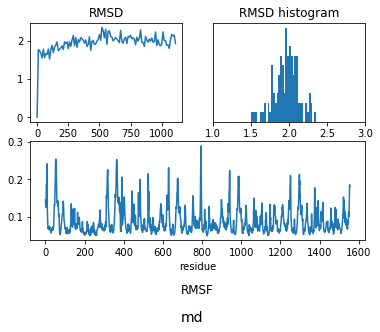

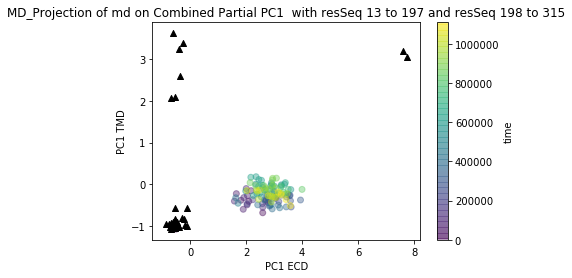

In [36]:
plotting("md","/media/scottzhuang/data/MD/4HFI_F238LI233T_pH46/repli2/",skip=10)